In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/posco/data/PKX.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-27,72.580002,72.980003,71.820000,72.790001,72.790001,132300
1,2021-09-28,70.660004,71.059998,70.089996,70.370003,70.370003,246800
2,2021-09-29,70.010002,70.050003,69.459999,69.639999,69.639999,142800
3,2021-09-30,69.930000,70.169998,68.900002,68.970001,68.970001,205400
4,2021-10-01,68.610001,69.160004,68.099998,68.989998,68.989998,181900


In [2]:
ts3 = df['High']
ts3.head()

0    72.980003
1    71.059998
2    70.050003
3    70.169998
4    69.160004
Name: High, dtype: float64

결측치 처리

In [3]:
ts3[ts3.isna()] 

Series([], Name: High, dtype: float64)

Series([], Name: High, dtype: float64)


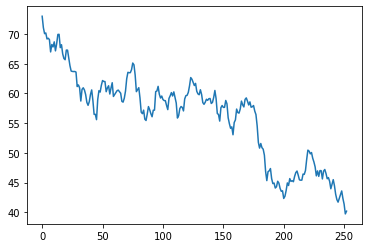

In [4]:
ts3=ts3.interpolate(method='time')
print(ts3[ts3.isna()])
plt.plot(ts3)

로그 변환

In [5]:
ts3_log = np.log(ts3)

In [6]:
from statsmodels.tsa.stattools import adfuller

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()   
    # 원본시계열, 이동평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='red',label='Original')    
    mean = plt.plot(rolmean, color='green', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller의 리턴 결과 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

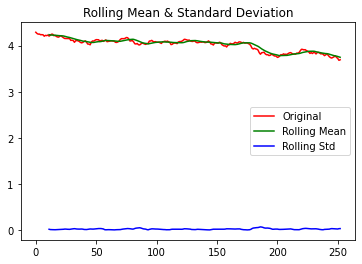

Results of Dickey-Fuller Test:
Test Statistic                  -0.818072
p-value                          0.813756
#Lags Used                       1.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


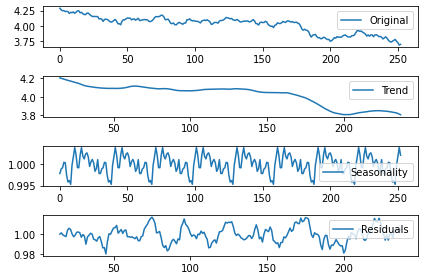

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts3_log, window=12)
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts3_log)
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts3_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Residual 안정성 확인

In [8]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.940236
p-value                          0.000029
#Lags Used                       1.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


학습, 테스트 데이터셋 분리

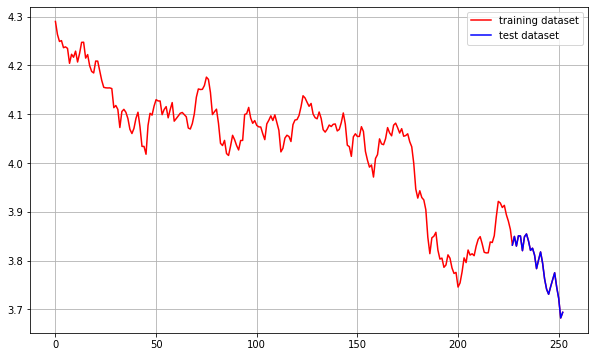

In [9]:
train_data, test_data = ts3_log[:int(len(ts3_log)*0.9)], ts3_log[int(len(ts3_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts3_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

ACF, PACF 그려보기 -> p,q 구하기

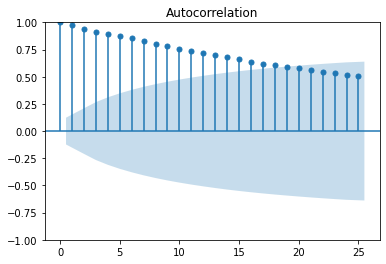

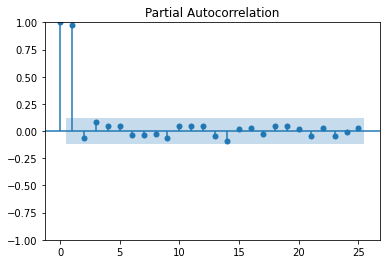

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts3_log)
plot_pacf(ts3_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.130541e+01
p-value                        1.276963e-20
#Lags Used                     1.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


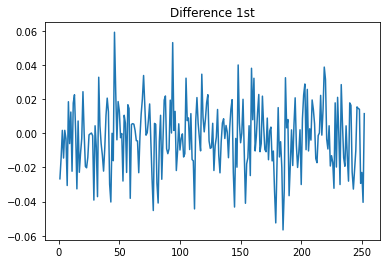

In [11]:
# 1차 차분 구하기
diff_1 = ts3_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

ARIMA 모델 빌드와 훈련

In [12]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  227
Model:                ARIMA(14, 1, 0)   Log Likelihood                 584.941
Date:                Wed, 28 Sep 2022   AIC                          -1139.882
Time:                        11:24:18   BIC                          -1088.574
Sample:                             0   HQIC                         -1119.177
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1971      0.074      2.654      0.008       0.052       0.343
ar.L2         -0.0733      0.079     -0.930      0.352      -0.228       0.081
ar.L3         -0.0592      0.066     -0.892      0.3

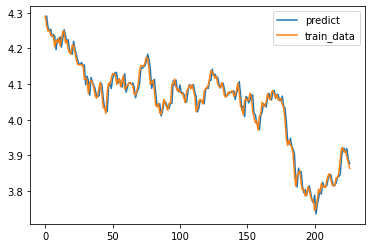

In [13]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

모델 테스트 및 플로팅

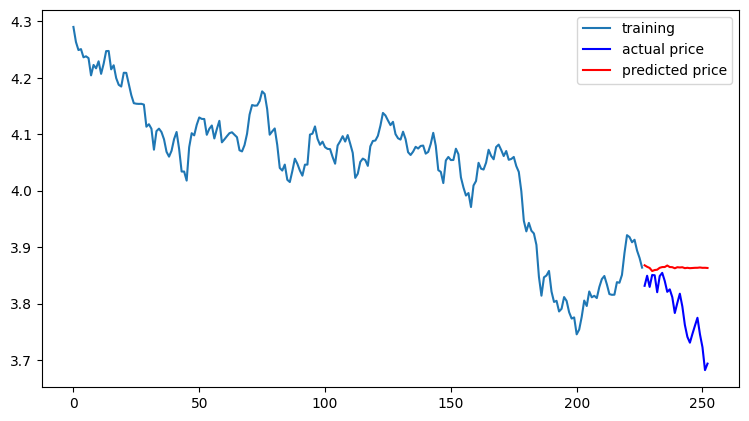

In [14]:
model = ARIMA(train_data, order=(14, 1, 0))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  15.322849955851096
MAE:  3.237091683738505
RMSE:  3.91444120607924
MAPE: 7.56%


In [ ]:
회고
- 이번 프로젝트에서 어려웠던 점
: 시계열 예측 전반에 대한 이해가 너무나 어려웠다. 그렇다 보니 ARIMA 모델의 개념을 이해할 때도 큰 어려움이 따랐다. 시간 내서 복습할 수 있도록...
- 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
: 모델 테스트 및 플로팅 과정에서 예상값이 실제 보다 크게 떨어짐에도 MAPE 값은 그럭저럭 낮게 나오고 있다. 잘 모르겠다.
- 루브릭 평가 지표를 맞추기 위해 시도한 것들:
: 교과서처럼 평가 기준에 제시된 내용에 맞추어 설명된 내용을 각각 순서대로 적용시켰다.
- 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정:
: 달성했다.
- 자기 다짐:
: 오늘도 잔다고 못낼 것 같아 새벽에 미리 적는다.... ex3 못낸게 너무 아쉽다.